In [1]:
#from google.colab import drive
#drive.mount("/content/drive")

In [7]:
from __future__ import print_function, division
import pandas as pd
from matplotlib.pyplot import imshow
import numpy as np
#import plotly.express as px
from PIL import Image
import torchvision
from torchvision import models, transforms
from torchvision import datasets, models, transforms
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import streamlit as st
# Setting Manual Seed for Recreation of results
torch.manual_seed(42)
np.random.seed(0)
import os
import matplotlib.pyplot as plt
import time
import os
import copy

In [8]:
%matplotlib inline

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './OUTPUT'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# Assign batch_size 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# Check your folder before going for train
class_names = image_datasets['train'].classes
class_names

['Apple', 'Banana', 'Jackfruit', 'Mango', 'Orange', 'images']

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



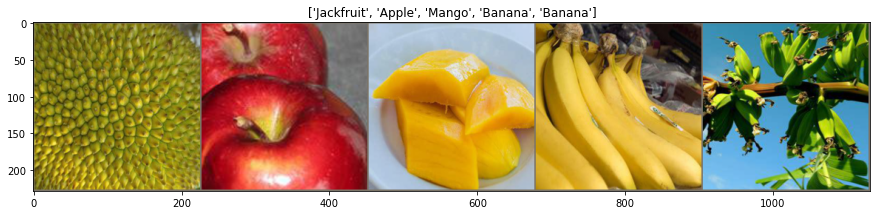

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(15, 15))
imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [8]:
 # Test input shape and labels of dataloader output
for inputs, labels in dataloaders["train"]:
    print(inputs.shape,labels.shape)
    print(labels)
    break

torch.Size([5, 3, 224, 224]) torch.Size([5])
tensor([3, 1, 2, 0, 3])


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
            
                imshow(out, title=[class_names[x] for x in classes])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR

# Model selection: Resnet18, Densenet161

In [13]:
# Resnet18
#model_ft = models.resnet18(pretrained=True)
#num_ftrs = model_ft.fc.in_features

In [14]:
# Densenet161
model_ft = models.densenet161(pretrained=True)
num_ftrs = model_ft.classifier.in_features

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [15]:

# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
num_classes=len(classes)
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [13]:
model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/1
----------
train Loss: 0.6281 Acc: 0.7794
val Loss: 0.2346 Acc: 0.9500

Epoch 1/1
----------
train Loss: 0.5126 Acc: 0.8120
val Loss: 0.2365 Acc: 0.9400

Training complete in 8m 59s
Best val Acc: 0.950000


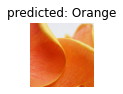

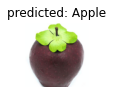

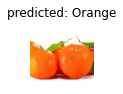

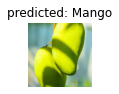

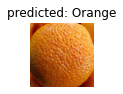

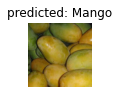

In [76]:
visualize_model(model_ft)

# Saving the finetuning model

In [17]:
# Specify a path
PATH = "Finetune-Densenet.pt"
# Save
torch.save(model, PATH)

In [ ]:
# Load
model = torch.load(PATH,map_location=torch.device('cpu'))
model.eval()

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.






# Model selection

In [ ]:
#Resnet18
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

In [ ]:
#model_conv =torchvision.models.densenet161(pretrained=True)
#for param in model_conv.parameters():
#    param.requires_grad = False
#num_ftrs = model_ft.classifier.in_features

In [78]:
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [79]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.2547 Acc: 0.4962
val Loss: 0.5139 Acc: 0.8600

Epoch 1/9
----------
train Loss: 0.8433 Acc: 0.7143
val Loss: 0.4030 Acc: 0.8700

Epoch 2/9
----------
train Loss: 0.8154 Acc: 0.7118
val Loss: 0.3232 Acc: 0.8800

Epoch 3/9
----------
train Loss: 0.7241 Acc: 0.7193
val Loss: 0.2635 Acc: 0.8600

Epoch 4/9
----------
train Loss: 0.6820 Acc: 0.7619
val Loss: 0.2231 Acc: 0.9400

Epoch 5/9
----------
train Loss: 0.6374 Acc: 0.7694
val Loss: 0.2103 Acc: 0.9300

Epoch 6/9
----------
train Loss: 0.6438 Acc: 0.7569
val Loss: 0.2134 Acc: 0.9300

Epoch 7/9
----------
train Loss: 0.5469 Acc: 0.7920
val Loss: 0.2031 Acc: 0.9300

Epoch 8/9
----------
train Loss: 0.5707 Acc: 0.7920
val Loss: 0.1928 Acc: 0.9500

Epoch 9/9
----------
train Loss: 0.5776 Acc: 0.7870
val Loss: 0.2069 Acc: 0.9400

Training complete in 8m 20s
Best val Acc: 0.950000


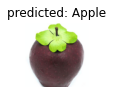

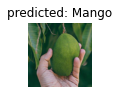

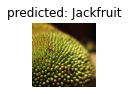

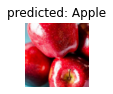

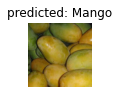

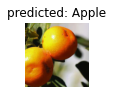

In [80]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Saving the feature extractor model

In [81]:
PATH= "feature_extractor_model.pt"
torch.save(model.state_dict(), PATH)